In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mhb-aug-dataset/augmented_data/images/ID_5f53ab26_ID_f1c7d54a53_slice_018_aug0.png
/kaggle/input/mhb-aug-dataset/augmented_data/images/ID_ba3a77dd_ID_70715be365_slice_018_aug3.png
/kaggle/input/mhb-aug-dataset/augmented_data/images/ID_56983eda_ID_a1eb0918d6_slice_013_aug1.png
/kaggle/input/mhb-aug-dataset/augmented_data/images/ID_790acb3f_ID_c294f81468_slice_016_aug4.png
/kaggle/input/mhb-aug-dataset/augmented_data/images/ID_a84354a5_ID_6699da85bb_slice_014_aug3.png
/kaggle/input/mhb-aug-dataset/augmented_data/images/ID_09b33fc4_ID_bcd322d4ed_slice_011_aug0.png
/kaggle/input/mhb-aug-dataset/augmented_data/images/ID_7d5594ff_ID_cb535d3e8b_slice_010_aug3.png
/kaggle/input/mhb-aug-dataset/augmented_data/images/ID_cb4c887c_ID_ec2a4643f3_slice_021_orig.png
/kaggle/input/mhb-aug-dataset/augmented_data/images/ID_e05b3047_ID_3d78428b2d_slice_017_aug1.png
/kaggle/input/mhb-aug-dataset/augmented_data/images/ID_10c64d22_ID_4c9aad31ca_slice_007_aug1.png
/kaggle/input/mhb-aug-dataset/

In [2]:
!pip install torch torchvision segmentation-models-pytorch numpy tqdm pillow scikit-learn matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 10.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.9.90
    Uninstalling nvidia-curand-cu12-1

In [3]:
import torch
import torch.nn as nn
import segmentation_models_pytorch as smp

class ResNetUNet(nn.Module):
    """
    UNet model with ResNet backbone using segmentation_models_pytorch
    """
    def __init__(self, num_classes=6, encoder_name="resnet101", pretrained=True):
        super(ResNetUNet, self).__init__()
        
        # Create the SMP UNet model with ResNet encoder
        self.model = smp.Unet(
            encoder_name=encoder_name,
            encoder_weights="imagenet" if pretrained else None,
            in_channels=1,  # Grayscale CT scan
            classes=num_classes,  # 5 hemorrhage types + background
            activation=None,  # Raw logits for CrossEntropyLoss
        )
        
        # Store encoder name for reference
        self.encoder_name = encoder_name
        
        # Easy access to encoder and decoder
        self.encoder = self.model.encoder
        self.decoder = self.model.decoder
        
    def forward(self, x):
        # Forward pass through the model
        return self.model(x)
    
    def freeze_encoder(self):
        """Freeze encoder weights for first training phase"""
        for param in self.encoder.parameters():
            param.requires_grad = False
            
    def unfreeze_encoder(self):
        """Unfreeze encoder weights for second training phase"""
        for param in self.encoder.parameters():
            param.requires_grad = True


def get_resnet_unet(in_channels=1, out_channels=6, pretrained=True):
    """
    Create a UNet model with ResNet-101 backbone
    
    Args:
        in_channels (int): Number of input channels (default: 1 for grayscale)
        out_channels (int): Number of output classes (default: 6 for hemorrhage types)
        pretrained (bool): Whether to use pretrained weights
        
    Returns:
        model (nn.Module): ResNetUNet model
    """
    model = ResNetUNet(
        num_classes=out_channels,
        encoder_name="resnet101",
        pretrained=pretrained
    )
    return model 

In [4]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import random
from sklearn.model_selection import train_test_split


class SimpleAugmentedDataset(Dataset):
    """Dataset class that simply loads pre-augmented data without applying transformations"""
    def __init__(self, image_paths, mask_paths):
        self.image_paths = image_paths
        self.mask_paths = mask_paths

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image
        img = Image.open(self.image_paths[idx])
        img_array = np.array(img, dtype=np.float32)
        
        # Load mask
        mask = Image.open(self.mask_paths[idx])
        mask_array = np.array(mask, dtype=np.int64)
        
        # Convert to tensors directly without additional transforms
        # Normalize the image to [-1, 1] range (assuming HU values are already processed in saved images)
        img_array = img_array / 127.5 - 1.0
        img_tensor = torch.from_numpy(img_array).unsqueeze(0).float()  # Add channel dimension
        mask_tensor = torch.from_numpy(mask_array).long()
        
        return img_tensor, mask_tensor


def get_dataset_paths():
    """Get all paired image and mask paths"""
    image_dir = '/kaggle/input/mhb-aug-dataset/augmented_data/images/'
    mask_dir = '/kaggle/input/mhb-aug-dataset/augmented_data/masks/'
    
    # Get all PNG files in the image directory
    all_images = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.png')]
    all_images.sort()  # Ensure consistent ordering
    
    # Create corresponding mask paths
    all_masks = []
    valid_images = []
    
    for img_path in all_images:
        # Get the corresponding mask path
        filename = os.path.basename(img_path)
        mask_path = os.path.join(mask_dir, filename)
        
        # Only include if both image and mask exist
        if os.path.exists(mask_path):
            valid_images.append(img_path)
            all_masks.append(mask_path)
    
    print(f"Found {len(valid_images)} valid image-mask pairs")
    return valid_images, all_masks


def create_simple_data_loaders(batch_size=8, val_split=0.15, test_split=0.15, seed=42, num_workers=2):
    """Create train, validation and test data loaders with NO augmentation - using pre-saved augmented data"""
    # Set random seed for reproducibility
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    # Get image and mask paths
    image_paths, mask_paths = get_dataset_paths()
    
    # Split into train, validation, and test sets
    train_imgs, test_imgs, train_masks, test_masks = train_test_split(
        image_paths, mask_paths, test_size=test_split, random_state=seed
    )
    
    train_imgs, val_imgs, train_masks, val_masks = train_test_split(
        train_imgs, train_masks, test_size=val_split/(1-test_split), random_state=seed
    )
    
    print(f"Training: {len(train_imgs)} samples")
    print(f"Validation: {len(val_imgs)} samples")
    print(f"Testing: {len(test_imgs)} samples")
    
    # Create simple datasets without transforms
    train_dataset = SimpleAugmentedDataset(train_imgs, train_masks)
    val_dataset = SimpleAugmentedDataset(val_imgs, val_masks)
    test_dataset = SimpleAugmentedDataset(test_imgs, test_masks)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    
    return train_loader, val_loader, test_loader

def get_class_weights(mask_paths, num_classes=6):
    """Calculate class weights to handle class imbalance"""
    class_counts = np.zeros(num_classes)
    
    print("Calculating class distribution...")
    for mask_path in mask_paths:
        mask = np.array(Image.open(mask_path))
        for c in range(num_classes):
            class_counts[c] += np.sum(mask == c)
    
    # Calculate weights (inverse frequency)
    total_pixels = np.sum(class_counts)
    class_weights = total_pixels / (class_counts * num_classes)
    
    # Replace infinities with a large number
    class_weights = np.nan_to_num(class_weights, nan=1.0, posinf=10.0, neginf=1.0)
    
    return torch.FloatTensor(class_weights)


In [5]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import multiprocessing
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import logging
import datetime
import csv
import argparse


# Set up logging
def setup_logging():
    """Set up the logging system"""
    # Create logs directory if it doesn't exist
    os.makedirs('logs', exist_ok=True)
    
    # Set up file name with timestamp
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    log_file = f"logs/training_resnet_{timestamp}.log"
    
    # Configure logging
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s [%(levelname)s] %(message)s',
        handlers=[
            logging.FileHandler(log_file),
            logging.StreamHandler()  # Also print to console
        ]
    )
    
    return log_file, timestamp

# Set up CSV logging for batch-level metrics
def setup_batch_logging(timestamp):
    """Set up CSV logging for batch-level metrics"""
    batch_log_file = f"/kaggle/working/logs/batch_metrics_resnet_{timestamp}.csv"
    
    # Create CSV file with headers
    with open(batch_log_file, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['Phase', 'Epoch', 'Batch', 'Loss', 'Dice_BG', 'Dice_EDH', 'Dice_IPH', 'Dice_IVH', 'Dice_SAH', 'Dice_SDH', 'Mean_Dice'])
    
    return batch_log_file

# Define metrics for semantic segmentation
def calculate_iou(pred, target, n_classes=6):
    """Calculate IoU (Intersection over Union) for each class"""
    ious = []
    pred = pred.view(-1)
    target = target.view(-1)
    
    # For each class
    for cls in range(n_classes):
        # True Positive (TP): prediction is cls and ground truth is cls
        pred_cls = pred == cls
        target_cls = target == cls
        
        intersection = (pred_cls & target_cls).sum()
        union = (pred_cls | target_cls).sum()
        
        if union.item() == 0:
            # If there is no ground truth of this class in this image, ignore it
            iou = torch.tensor(1.0)
        else:
            iou = intersection.float() / union.float()
        
        ious.append(iou.item())
    
    return ious

def calculate_dice(pred, target, n_classes=6):
    """Calculate Dice coefficient for each class"""
    dices = []
    pred = pred.view(-1)
    target = target.view(-1)
    
    # For each class
    for cls in range(n_classes):
        pred_cls = pred == cls
        target_cls = target == cls
        
        intersection = (pred_cls & target_cls).sum()
        cardinality = pred_cls.sum() + target_cls.sum()
        
        if cardinality.item() == 0:
            # If there is no ground truth and no prediction of this class, dice = 1
            dice = torch.tensor(1.0)
        else:
            dice = (2.0 * intersection) / cardinality
        
        dices.append(dice.item())
    
    return dices

def log_batch_metrics(batch_log_file, phase, epoch, batch_idx, loss, dices):
    """Log batch metrics to CSV file"""
    mean_dice = np.mean(dices)
    
    with open(batch_log_file, 'a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([phase, epoch, batch_idx, loss] + dices + [mean_dice])

def save_prediction_sample(images, masks, preds, sample_idx, class_names, phase=0, epoch=0):
    """Save visualization of predictions"""
    # Move tensors to CPU and convert to numpy
    image = images[0].cpu().numpy()[0]  # First image in batch, remove channel dim
    mask = masks[0].cpu().numpy()       # First mask in batch
    pred = preds[0].cpu().numpy()       # First prediction in batch
    
    # Create a colormap for visualization
    cmap = plt.cm.get_cmap('viridis', len(class_names))
    
    plt.figure(figsize=(15, 5))
    
    # Plot original image
    plt.subplot(1, 3, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    
    # Plot ground truth mask
    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap=cmap, vmin=0, vmax=len(class_names)-1)
    plt.colorbar(ticks=range(len(class_names)), label='Class')
    plt.title('Ground Truth')
    plt.axis('off')
    
    # Plot prediction
    plt.subplot(1, 3, 3)
    plt.imshow(pred, cmap=cmap, vmin=0, vmax=len(class_names)-1)
    plt.colorbar(ticks=range(len(class_names)), label='Class')
    plt.title('Prediction')
    plt.axis('off')
    
    # Create directory if it doesn't exist
    os.makedirs('results_resnet/predictions', exist_ok=True)
    
    # Save figure
    plt.tight_layout()
    plt.savefig(f'results_resnet/predictions/phase{phase}_epoch{epoch}_sample{sample_idx}.png')
    plt.close()

def train():
    # Set up logging
    log_file, timestamp = setup_logging()
    batch_log_file = setup_batch_logging(timestamp)
    
    logging.info("Starting two-phase training with ResNet-101 UNet and augmented dataset")
    
    # Create output directory for results
    os.makedirs('results_resnet', exist_ok=True)
    
    # Create data loaders with simple data loader that doesn't apply augmentations
    train_loader, val_loader, test_loader = create_simple_data_loaders(batch_size=8, num_workers=0)
    
    # Get class weights for handling imbalance
    image_paths, mask_paths = get_dataset_paths()
    class_weights = get_class_weights(mask_paths)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    logging.info(f"Using device: {device}")
    
    # Set class weights for loss function
    class_weights = class_weights.to(device)
    logging.info(f"Class weights: {class_weights.cpu().numpy()}")
    
    # Define model
    model = get_resnet_unet(in_channels=1, out_channels=6, pretrained=True).to(device)  # 6 classes: background + 5 hemorrhage types
    logging.info(f"Model initialized with {sum(p.numel() for p in model.parameters())} parameters")
    
    # Use weighted CrossEntropyLoss for multiclass segmentation
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    
    # Training tracking
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    class_names = ['Background', 'EDH', 'IPH', 'IVH', 'SAH', 'SDH']
    
    # Two-phase training
    phase1_epochs = 5  # Freeze encoder and train decoder only
    phase2_epochs = 30  # Unfreeze encoder and train full model
    
    # Phase 1: Freeze encoder and train decoder only
    logging.info("Phase 1: Training decoder only (encoder frozen)")
    model.freeze_encoder()
    
    # Use higher learning rate for decoder only
    optimizer = torch.optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=1e-3,
        weight_decay=1e-4
    )
    
    # Phase 1 training
    for epoch in range(phase1_epochs):
        model.train()
        running_loss = 0.0
        epoch_dice_scores = np.zeros(6)
        batch_count = 0
        
        # Training loop
        progress_bar = tqdm(train_loader, desc=f"Phase 1 - Epoch {epoch+1}/{phase1_epochs}")
        for batch_idx, (images, masks) in enumerate(progress_bar):
            images = images.to(device)
            masks = masks.to(device)
            
            # Forward pass
            outputs = model(images)  # Shape: (B, 6, H, W)
            loss = criterion(outputs, masks)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            # Get predictions and calculate Dice score
            preds = torch.argmax(outputs, dim=1)
            batch_dices = calculate_dice(preds, masks)
            epoch_dice_scores += np.array(batch_dices)
            batch_count += 1
            
            # Log batch metrics
            log_batch_metrics(batch_log_file, 1, epoch+1, batch_idx+1, loss.item(), batch_dices)
            
            # Update progress bar
            running_loss += loss.item()
            mean_dice = np.mean(batch_dices)
            progress_bar.set_postfix({
                "Loss": f"{loss.item():.4f}",
                "Dice": f"{mean_dice:.4f}"
            })
        
        # Average training metrics for epoch
        avg_train_loss = running_loss / len(train_loader)
        avg_train_dice = epoch_dice_scores / batch_count
        mean_train_dice = np.mean(avg_train_dice)
        
        train_losses.append(avg_train_loss)
        
        # Log epoch training metrics
        logging.info(f"Phase 1 - Epoch {epoch+1}/{phase1_epochs}")
        logging.info(f"  Train Loss: {avg_train_loss:.4f}, Mean Dice: {mean_train_dice:.4f}")
        
        # Validation loop
        model.eval()
        val_loss = 0.0
        class_ious = np.zeros(6)
        class_dices = np.zeros(6)
        val_samples = 0
        
        with torch.no_grad():
            for images, masks in tqdm(val_loader, desc="Validation"):
                images = images.to(device)
                masks = masks.to(device)
                
                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()
                
                # Get predictions
                preds = torch.argmax(outputs, dim=1)
                
                # Calculate IoU and Dice for each batch
                ious = calculate_iou(preds, masks)
                dices = calculate_dice(preds, masks)
                
                # Accumulate metrics
                class_ious += np.array(ious)
                class_dices += np.array(dices)
                val_samples += 1
                
                # Save a sample prediction
                if epoch == 0 and val_samples == 1:
                    save_prediction_sample(images, masks, preds, 0, class_names, phase=1, epoch=epoch)
        
        # Average validation metrics
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        avg_class_ious = class_ious / val_samples
        avg_class_dices = class_dices / val_samples
        
        # Calculate mean metrics
        mean_iou = np.mean(avg_class_ious)
        mean_dice = np.mean(avg_class_dices)
        
        # Log validation metrics
        logging.info(f"  Val Loss: {avg_val_loss:.4f}, Mean IoU: {mean_iou:.4f}, Mean Dice: {mean_dice:.4f}")
        logging.info("  Per-class validation metrics:")
        
        for i, class_name in enumerate(class_names):
            logging.info(f"    {class_name}: IoU={avg_class_ious[i]:.4f}, Dice={avg_class_dices[i]:.4f}")
        
        # Save best model from Phase 1
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'results_resnet/best_phase1_resnet101_model.pth')
            logging.info("  New best Phase 1 model saved!")
    
    # Phase 2: Unfreeze encoder and train full model
    logging.info("Phase 2: Training full model (encoder unfrozen)")
    model.unfreeze_encoder()
    
    # Use lower learning rate for full model
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    
    # Reset best validation loss for Phase 2
    best_val_loss = float('inf')
    
    # Phase 2 training
    for epoch in range(phase2_epochs):
        model.train()
        running_loss = 0.0
        epoch_dice_scores = np.zeros(6)
        batch_count = 0
        
        # Training loop
        progress_bar = tqdm(train_loader, desc=f"Phase 2 - Epoch {epoch+1}/{phase2_epochs}")
        for batch_idx, (images, masks) in enumerate(progress_bar):
            images = images.to(device)
            masks = masks.to(device)
            
            # Forward pass
            outputs = model(images)  # Shape: (B, 6, H, W)
            loss = criterion(outputs, masks)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            # Get predictions and calculate Dice score
            preds = torch.argmax(outputs, dim=1)
            batch_dices = calculate_dice(preds, masks)
            epoch_dice_scores += np.array(batch_dices)
            batch_count += 1
            
            # Log batch metrics
            log_batch_metrics(batch_log_file, 2, epoch+1, batch_idx+1, loss.item(), batch_dices)
            
            # Update progress bar
            running_loss += loss.item()
            mean_dice = np.mean(batch_dices)
            progress_bar.set_postfix({
                "Loss": f"{loss.item():.4f}",
                "Dice": f"{mean_dice:.4f}"
            })
        
        # Average training metrics for epoch
        avg_train_loss = running_loss / len(train_loader)
        avg_train_dice = epoch_dice_scores / batch_count
        mean_train_dice = np.mean(avg_train_dice)
        
        train_losses.append(avg_train_loss)
        
        # Log epoch training metrics
        logging.info(f"Phase 2 - Epoch {epoch+1}/{phase2_epochs}")
        logging.info(f"  Train Loss: {avg_train_loss:.4f}, Mean Dice: {mean_train_dice:.4f}")
        
        # Validation loop
        model.eval()
        val_loss = 0.0
        class_ious = np.zeros(6)
        class_dices = np.zeros(6)
        val_samples = 0
        
        with torch.no_grad():
            for images, masks in tqdm(val_loader, desc="Validation"):
                images = images.to(device)
                masks = masks.to(device)
                
                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()
                
                # Get predictions
                preds = torch.argmax(outputs, dim=1)
                
                # Calculate IoU and Dice for each batch
                ious = calculate_iou(preds, masks)
                dices = calculate_dice(preds, masks)
                
                # Accumulate metrics
                class_ious += np.array(ious)
                class_dices += np.array(dices)
                val_samples += 1
                
                # Save a sample prediction
                if epoch % 5 == 0 and val_samples == 1:
                    save_prediction_sample(images, masks, preds, 0, class_names, phase=2, epoch=epoch)
        
        # Average validation metrics
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        avg_class_ious = class_ious / val_samples
        avg_class_dices = class_dices / val_samples
        
        # Calculate mean metrics
        mean_iou = np.mean(avg_class_ious)
        mean_dice = np.mean(avg_class_dices)
        
        # Log validation metrics
        logging.info(f"  Val Loss: {avg_val_loss:.4f}, Mean IoU: {mean_iou:.4f}, Mean Dice: {mean_dice:.4f}")
        logging.info("  Per-class validation metrics:")
        
        for i, class_name in enumerate(class_names):
            logging.info(f"    {class_name}: IoU={avg_class_ious[i]:.4f}, Dice={avg_class_dices[i]:.4f}")
        
        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'results_resnet/best_resnet101_model.pth')
            logging.info("  New best model saved!")
    
    # Save final model
    torch.save(model.state_dict(), 'results_resnet/final_resnet101_model.pth')
    logging.info("Final model saved")
    
    # Plot training curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.axvline(x=phase1_epochs, color='r', linestyle='--', label='Phase 1 → Phase 2')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('ResNet-101 UNet: Training and Validation Loss')
    plt.legend()
    plt.savefig('results_resnet/loss_curve.png')
    logging.info("Loss curve saved to results_resnet/loss_curve.png")
    
    # Test the final model
    test_model(model, test_loader, device, class_names)
    
    logging.info("Training complete!")

def test_model(model, test_loader, device, class_names):
    """Evaluate model performance on test set"""
    logging.info("Evaluating model on test set")
    
    model.eval()
    class_ious = np.zeros(6)
    class_dices = np.zeros(6)
    test_samples = 0
    
    with torch.no_grad():
        for i, (images, masks) in enumerate(tqdm(test_loader, desc="Testing")):
            images = images.to(device)
            masks = masks.to(device)
            
            # Forward pass
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            
            # Calculate metrics
            ious = calculate_iou(preds, masks)
            dices = calculate_dice(preds, masks)
            
            # Accumulate metrics
            class_ious += np.array(ious)
            class_dices += np.array(dices)
            test_samples += 1
            
            # Save a few example predictions for visualization
            if i < 5:
                save_prediction_sample(images, masks, preds, i, class_names, phase=3, epoch=0)
    
    # Average test metrics
    avg_class_ious = class_ious / test_samples
    avg_class_dices = class_dices / test_samples
    
    # Calculate mean metrics
    mean_iou = np.mean(avg_class_ious)
    mean_dice = np.mean(avg_class_dices)
    
    logging.info("\nTest Results:")
    logging.info(f"  Mean IoU: {mean_iou:.4f}")
    logging.info(f"  Mean Dice: {mean_dice:.4f}")
    
    # Log per-class metrics
    logging.info("  Per-class test metrics:")
    for i, class_name in enumerate(class_names):
        logging.info(f"    {class_name}: IoU={avg_class_ious[i]:.4f}, Dice={avg_class_dices[i]:.4f}")
    
    # Save results to CSV
    with open('results_resnet/test_results.csv', 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['Class', 'IoU', 'Dice'])
        for i, class_name in enumerate(class_names):
            writer.writerow([class_name, f"{avg_class_ious[i]:.4f}", f"{avg_class_dices[i]:.4f}"])
        writer.writerow(['Mean', f"{mean_iou:.4f}", f"{mean_dice:.4f}"])


Found 14418 valid image-mask pairs
Training: 10092 samples
Validation: 2163 samples
Testing: 2163 samples
Found 14418 valid image-mask pairs
Calculating class distribution...


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/179M [00:00<?, ?B/s]

Validation:   0%|          | 0/271 [00:00<?, ?it/s]/tmp/ipykernel_19/256097328.py:116: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', len(class_names))
Testing: 100%|██████████| 271/271 [01:15<00:00,  3.61it/s]


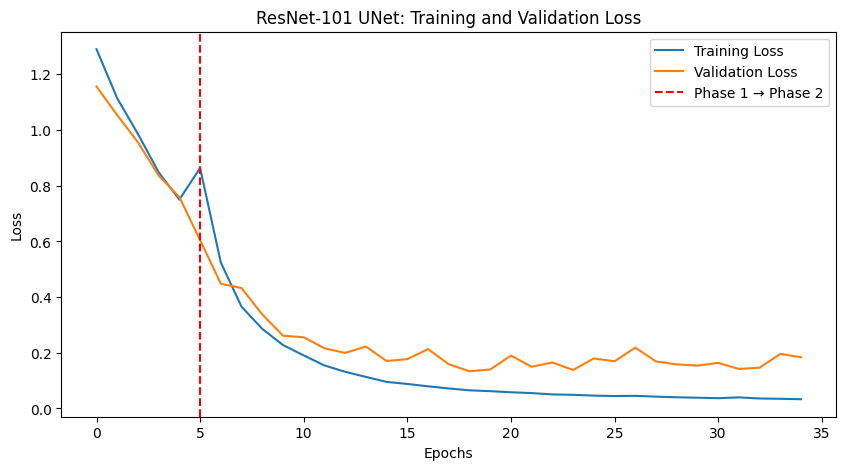

In [6]:
multiprocessing.freeze_support()

train() 